In [1]:
# lets try doing all this in pytoooorch

In [4]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset


from source import Dataset as ds
from sklearn.model_selection import train_test_split

import matplotlib as mpl
import matplotlib.pyplot as plt

In [5]:
#selecting features 
branches_to_use = [
"cscRechitClusterX",
"cscRechitClusterY",
"cscRechitClusterZ",
"cscRechitClusterTimeWeighted",
"cscRechitClusterTimeSpreadWeightedAll",
"cscRechitClusternXY",
"cscRechitClusternZ",
"cscRechitClusterXSpread",
"cscRechitClusterYSpread",
"cscRechitClusterZSpread",
"cscRechitClusterXYSpread",
"cscRechitClusterRSpread",
"cscRechitClusterEtaPhiSpread",
"cscRechitClusterEtaSpread",
"cscRechitClusterPhiSpread",
"cscRechitClusterDeltaRSpread",
"cscRechitClusterMajorAxis",
"cscRechitClusterMinorAxis",
"cscRechitClusterSkewX",
"cscRechitClusterSkewY",
"cscRechitClusterSkewZ",
"cscRechitClusterKurtX",
"cscRechitClusterKurtY",
"cscRechitClusterKurtZ", 
"cscRechitClusterSize",
"cscRechitCluster_match_gLLP_e"
]

#energy key
truth_value = "cscRechitCluster_match_gLLP_e"
size_value = "cscRechitClusterSize"

#read data
dataset_signal = ds.Dataset("signal")
df_signal = dataset_signal.load_df("/nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets/test_df_v6.h5")

#cut clusters which don't have LLP
olen = len(df_signal)
df_signal = df_signal[ df_signal["cscRechitCluster_match_gLLP"]>=1 ]
print('cut out ' + str(olen - len(df_signal)) + ' clusters, which leaves ' + str(len(df_signal)) + ' clusters containing a LLP decay for training')


OSError: ``/nfs/dust/cms/user/loewetob/ML_LLP/MDS_regression/datasets`` does not exist

In [ ]:
class mdsDataset(Dataset):
    def __init__(self, dataframe, feature_keys = branches_to_use[:-1], label_key = branches_to_use[-1]):
        self.dataframe = dataframe
        self.feature_keys = feature_keys
        self.label_key = label_key

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        sample = {
            'features': torch.tensor(self.dataframe.iloc[idx][self.feature_keys].tolist(), dtype=torch.float32),
            'label': torch.tensor(self.dataframe.iloc[idx][self.label_key], dtype=torch.float32).squeeze()
        }
        return sample

In [5]:
class MyModel(nn.Module):
    def __init__(self, input_size, layers = [50, 30, 20, 5, 1]):
        super(MyModel, self).__init__()
        
        self.fc_layers = nn.ModuleList()  # ModuleList to hold dynamically created layers
        
        # first layer
        self.fc_layers.append(nn.Linear(input_size, layers[0]))
        self.fc_layers.append(nn.ReLU())
        
        # other layers
        for i in range(len(layers) - 1):
            self.fc_layers.append(nn.Linear(layers[i], layers[i + 1]))
            self.fc_layers.append(nn.ReLU())

    def forward(self, x):
        for layer in self.fc_layers:
            x = layer(x)
        return x

In [6]:
model = MyModel(input_size=25)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [7]:
train_data, testval_data = train_test_split(df_signal, train_size=0.6)
test_data, val_data = train_test_split(testval_data, test_size=0.5)

batch_size = 2048

train_dataset = mdsDataset(dataframe = train_data)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_dataset = mdsDataset(dataframe = val_data)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_dataset = mdsDataset(dataframe = test_data)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [8]:
best_val_loss = float('inf')
num_epochs = 10

for epoch in range(num_epochs):
    # Training loop
    print('EPOCH' + str(epoch))
    model.train()
    for batch in train_loader:
        inputs = batch['features']
        labels = batch['label']
        optimizer.zero_grad()
        outputs = torch.flatten(model(inputs))
        loss = criterion(outputs, labels)
        print('train loss ' + str(loss.item()))
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    with torch.no_grad():
        for batch in val_loader:
            inputs = batch['features']
            labels = batch['label']
            outputs = torch.flatten(model(inputs))
            val_loss = criterion(outputs, labels)
            print('val loss ' + str(val_loss.item()))
            # Calculate additional validation metrics if needed

            # Save the model if it has the best validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model.state_dict(), 'best_model.pth')
print('best val loss' + str(best_val_loss))

EPOCH0
train loss 29620.509765625
train loss 28364.580078125
train loss 27503.787109375
train loss 23455.439453125
train loss 18754.05859375
train loss 13111.4140625
train loss 7693.14599609375
train loss 10921.6328125
train loss 12918.53125
train loss 10440.205078125
train loss 8006.73779296875
train loss 7777.0791015625
train loss 7619.8056640625
train loss 8544.779296875
train loss 9624.9140625
train loss 8220.8798828125
train loss 9226.6513671875
train loss 7170.88134765625
train loss 6426.58447265625
train loss 7149.3701171875
train loss 7645.49267578125
train loss 7784.98876953125
train loss 7121.0732421875
train loss 8344.49609375
val loss tensor(5882.6455)
val loss tensor(6003.6870)
val loss tensor(7526.7095)
val loss tensor(5391.0430)
val loss tensor(7086.5034)
val loss tensor(7623.7139)
val loss tensor(5652.1396)
val loss tensor(7249.8989)
EPOCH1
train loss 5941.71533203125
train loss 5754.3359375
train loss 6579.876953125
train loss 6641.2724609375
train loss 6362.8237304687

In [9]:
def predict_plot(pred, test_labels, title = None, axlabels = ('clusters', 'generated particle energy')):
    fig, ax = plt.subplots(figsize = (6, 4))
    
    histdata, bins, dummy = ax.hist(test_labels, bins = 50, histtype="step", color = 'b', label = 'truth')
    ax.hist(pred, bins = bins, histtype="step", color = 'r', label = 'predictions')
    ax.set_yscale('log')
    ax.set_ylabel(axlabels[0])
    ax.set_xlabel(axlabels[1])
    ax.legend()
    if title:
        ax.set_title(title)

In [10]:
model.eval()

labels = []
predictions = []

with torch.no_grad():
    for batch in test_loader:
        inputs = batch['features']
        label = batch['label']
        prediction = torch.flatten(model(inputs))
        predictions.append(prediction)
        labels.append(label)

In [11]:
p = [tensor.item() for tensor in predictions]
l = [tensor.item() for tensor in labels]

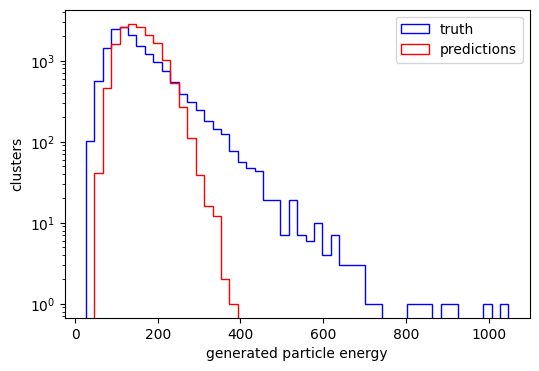

In [12]:
predict_plot(p, l)